In [3]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
% matplotlib inline

# Gather

In [141]:
# Reading the archive.csv for tweets of @dog_rates into a DataFrame
twt_archv_df = pd.read_csv('twitter-archive-enhanced.csv')

In [21]:
# Downloading the tweet image predictions programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [142]:
# Reading the Image Predictions.tsv-by-a-neural-network into a DataFrame
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are intentionally hidden (after run) to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twt_archv_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop took 31.89 minutes to run including Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        # Printing out each tweet ID after it was queried
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

25 out of 2356 fail for the query of Twitter API, and these are maybe because of deleted tweets. So, they are skipped. The rest 2331 shall be processed then.

In [143]:
# Reading the json.txt file for the tweets data
tweets_list = []

with open('tweet_json.txt', encoding='utf-8') as file:
    for line in file:
        tweets_list.append(json.loads(line))
        
tweets_df = pd.DataFrame(tweets_list)

#user_list = pd.Series(tweets_df.user).tolist()
#user_df = pd.DataFrame(user_list)
# All user_df refer to the same user which is dog_rates. So, it is skipped

#place_list = pd.Series(tweets_df.place).tolist()
#place_df = pd.DataFrame(place_list)
# Just one entry for the 'place' attribute in the whole tweets_df; in Clifton, NJ, US. So, it is skipped

In [144]:
# As per the key point wanting original ratings (no retweets) that have images
id_ls1 = tweets_df.id
id_ls2 = image_predictions.tweet_id
id_ls3 = twt_archv_df.tweet_id
tweets_df = tweets_df[tweets_df['id'].isin(set(id_ls1)&set(id_ls2))]
tweets_df = tweets_df[~(tweets_df.retweeted_status.notnull())]
id_ls1 = tweets_df.id
twt_archv_df = twt_archv_df[twt_archv_df['tweet_id'].isin(set(id_ls1)&set(id_ls3))]
image_predictions = image_predictions[image_predictions['tweet_id'].isin(set(id_ls1)&set(id_ls2))]

# Assess
## Quality
- TimeStamp is of the wrong data type.
- IDs are of the wrong datatypes.
- Some have multi dog stage!
- One has a wrong rating of 1/2
- A tweet with 2 dogs and no names for neither, however, the name attribute is not None
- 'contributors', 'coordinates', 'geo', 'place' and 'retweeted' attributes are almost all NaN's through the tweets_df
- Unnecessary columns in tweets from API include 'user'> same user, 'favorited' and 'truncated' > all false.
- 25 tweets have been deleted from Twitter API, thus these from the Archive do not have 'retweet_count' nor 'favorite_count'
- IDs of tweets sometimes called 'id' while others called 'tweet_id'
- Fake rating of id:810984652412424192 as 24/7

## Tidiness
- Dog stags: doggo, floofer, pupper	and puppo columns in the Archive violates the 1st rule of tidiness.
- 'retweet_count' and 'favorite_count' in the tweets_df refer to the data in the Archive DataFrame, violating the 3rd rule of tidiness
- Image predictions data frame also is a data related to the ones in the Archive and the API.

# Clean
## Code

In [217]:
# Reading copied dataFrame
twt_archv_filt = twt_archv_df.copy()
img_pred_filt = image_predictions.copy()
twt_api_filt = tweets_df.copy()

In [218]:
twt_api_filt = twt_api_filt.loc[:,['favorite_count','id','retweet_count']]
twt_archv_filt.drop(columns=['source','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace=True)
twt_archv_filt.timestamp = pd.to_datetime(twt_archv_filt.timestamp)

In [219]:
# Figuiring out 11 duplicated DogStages as
twt_archv_filt[(twt_archv_filt.doggo=='doggo')&(twt_archv_filt.pupper=='pupper')]
twt_archv_filt[(twt_archv_filt.doggo=='doggo')&(twt_archv_filt.floofer=='floofer')]
twt_archv_filt[(twt_archv_filt.doggo=='doggo')&(twt_archv_filt.puppo=='puppo')]
# Cleaning
twt_archv_filt.loc[twt_archv_filt.tweet_id==855851453814013952,'doggo'] = 'None'
twt_archv_filt.loc[twt_archv_filt.tweet_id==854010172552949760,'doggo'] = 'None'
twt_archv_filt.loc[twt_archv_filt.tweet_id==817777686764523521,'doggo'] = 'None'
twt_archv_filt.loc[twt_archv_filt.tweet_id==808106460588765185,['doggo','pupper']] = 'None' # more than one dog
twt_archv_filt.loc[twt_archv_filt.tweet_id==802265048156610565,['doggo','pupper']] = 'None' # more than one dog
twt_archv_filt.loc[twt_archv_filt.tweet_id==801115127852503040,'doggo'] = 'None'
twt_archv_filt.loc[twt_archv_filt.tweet_id==785639753186217984,['doggo','pupper']] = 'None' # Not a dog 
twt_archv_filt.loc[twt_archv_filt.tweet_id==759793422261743616,['doggo','pupper']] = 'None' # more than one dog
twt_archv_filt.loc[twt_archv_filt.tweet_id==751583847268179968,'pupper'] = 'None'
twt_archv_filt.loc[twt_archv_filt.tweet_id==741067306818797568,['doggo','pupper']] = 'None' # more than one dog
twt_archv_filt.loc[twt_archv_filt.tweet_id==741067306818797568,'name'] = 'None' # A tweet with 2 dogs and no names
twt_archv_filt.loc[twt_archv_filt.tweet_id==733109485275860992,['doggo','pupper']] = 'None' # more than one dog

In [220]:
twt_archv_filt.loc[(twt_archv_filt.doggo==twt_archv_filt.floofer)&
                   (twt_archv_filt.pupper==twt_archv_filt.puppo), 'doggo'] = 'not_doggo'
twt_archv_filt = pd.melt(twt_archv_filt, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
                                                  'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                         var_name='tmp_stage', value_name='dog_stage')
twt_archv_filt = twt_archv_filt[twt_archv_filt.dog_stage != 'None']
twt_archv_filt['dog_stage'].replace('not_doggo',np.nan, inplace=True)
twt_archv_filt.drop(columns=['tmp_stage'], inplace=True)
twt_archv_filt.reset_index(drop=True, inplace=True)

In [249]:
twt_archv_filt.loc[:,['tweet_id','in_reply_to_status_id','in_reply_to_user_id']] = twt_archv_filt.astype({
    'tweet_id':str,'in_reply_to_status_id':str,'in_reply_to_user_id':str})
twt_archv_filt.in_reply_to_status_id.replace('nan',np.nan, inplace=True)
twt_archv_filt.in_reply_to_user_id.replace('nan',np.nan, inplace=True)
twt_api_filt.loc[:,['id']] = twt_api_filt.astype({'id':str})
img_pred_filt.loc[:,['tweet_id']] = img_pred_filt.astype({'tweet_id':str})

In [256]:
# Testing
twt_archv_filt.info()
twt_api_filt.info()
img_pred_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
tweet_id                 1987 non-null object
in_reply_to_status_id    23 non-null object
in_reply_to_user_id      23 non-null object
timestamp                1987 non-null datetime64[ns]
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
dog_stage                299 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 155.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    1987 non-null int64
tweet_id          1987 non-null object
retweet_count     1987 non-null int64
dtypes: int64(2), object(1)
memory usage: 62.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2074
Data columns (t

In [252]:
twt_archv_filt.loc[twt_archv_filt.rating_numerator==1,'rating_numerator'] = 9
twt_archv_filt.loc[twt_archv_filt.rating_denominator==2,'rating_denominator'] = 10
twt_api_filt.rename(columns={'id':'tweet_id'}, inplace=True)

In [257]:
# Making our data Tidy
frst_mrg = pd.merge(twt_archv_filt, twt_api_filt, on='tweet_id')
scnd_mrg = pd.merge(frst_mrg, img_pred_filt, on='tweet_id')
# Now we can solve last quality issue, by deleting the whole row of the fake rating
scnd_mrg.drop(index=345,inplace=True)

In [258]:
# Test
scnd_mrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1986
Data columns (total 23 columns):
tweet_id                 1986 non-null object
in_reply_to_status_id    23 non-null object
in_reply_to_user_id      23 non-null object
timestamp                1986 non-null datetime64[ns]
text                     1986 non-null object
expanded_urls            1986 non-null object
rating_numerator         1986 non-null int64
rating_denominator       1986 non-null int64
name                     1986 non-null object
dog_stage                299 non-null object
favorite_count           1986 non-null int64
retweet_count            1986 non-null int64
jpg_url                  1986 non-null object
img_num                  1986 non-null int64
p1                       1986 non-null object
p1_conf                  1986 non-null float64
p1_dog                   1986 non-null bool
p2                       1986 non-null object
p2_conf                  1986 non-null float64
p2_dog               

In [259]:
scnd_mrg.to_csv('twitter_archive_master.csv', index=False)

# Analysis

In [4]:
twt_archv_mstr = pd.read_csv('twitter_archive_master.csv')
twt_archv_mstr.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1843,703268521220972544,NaN,NaN,2016-02-26 17:20:56,Happy Friday here's a sleepy pupper 12/10 http...,https://twitter.com/dog_rates/status/703268521...,12,10,None,pupper,...,1,wool,0.525434,False,fur_coat,0.236391,False,kuvasz,0.038243,True
1592,668892474547511297,NaN,NaN,2015-11-23 20:42:48,This is Ruffles. He is an Albanian Shoop Da Wh...,https://twitter.com/dog_rates/status/668892474...,11,10,Ruffles,NaN,...,1,kelpie,0.421979,True,collie,0.227060,True,Cardigan,0.168211,True
152,849412302885593088,NaN,NaN,2017-04-05 00:04:08,This is Noosh. He noticed you were in the show...,https://twitter.com/dog_rates/status/849412302...,12,10,Noosh,NaN,...,4,schipperke,0.907559,True,crossword_puzzle,0.017934,False,Chihuahua,0.016191,True
1716,666430724426358785,NaN,NaN,2015-11-17 01:40:41,Oh boy what a pup! Sunglasses take this one to...,https://twitter.com/dog_rates/status/666430724...,6,10,None,NaN,...,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
1762,874296783580663808,NaN,NaN,2017-06-12 16:06:11,This is Jed. He may be the fanciest pupper in ...,https://twitter.com/dog_rates/status/874296783...,13,10,Jed,pupper,...,1,cocker_spaniel,0.437216,True,miniature_poodle,0.277191,True,toy_poodle,0.157402,True


In [5]:
twt_archv_mstr.loc[:,['tweet_id','in_reply_to_status_id','in_reply_to_user_id']] = twt_archv_mstr.astype({
    'tweet_id':str,'in_reply_to_status_id':str,'in_reply_to_user_id':str})
# For simplicity of analysis, only needed rows would be displayed
twt_archv_mstr = twt_archv_mstr.iloc[:,np.r_[0:4,6:12,14:23]]

In [6]:
twt_archv_mstr.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,p1_conf,p2_conf,p3_conf
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1.986000e+03,1.986000e+03
mean,12.295065,10.539778,8122.270393,2399.928499,0.593177,1.345218e-01,6.038854e-02
std,41.576848,7.332456,11962.777682,4293.901507,0.271956,1.005720e-01,5.092234e-02
min,0.000000,10.000000,70.000000,11.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,1737.500000,537.250000,0.360998,5.415523e-02,1.624755e-02
50%,11.000000,10.000000,3655.000000,1160.000000,0.587222,1.175370e-01,4.959335e-02
75%,12.000000,10.000000,10101.000000,2733.500000,0.843883,1.951377e-01,9.186877e-02
max,1776.000000,170.000000,153185.000000,75908.000000,1.000000,4.880140e-01,2.734190e-01


In [7]:
twt_archv_mstr[twt_archv_mstr.rating_numerator==0]
twt_archv_mstr[twt_archv_mstr.rating_numerator==1776]
max_idx = twt_archv_mstr[twt_archv_mstr['rating_numerator']==1776].index
twt_archv_mstr[twt_archv_mstr.rating_numerator==max(twt_archv_mstr['rating_numerator'].drop(max_idx))].index
twt_archv_mstr[twt_archv_mstr.rating_numerator==max(twt_archv_mstr['rating_numerator'].drop([1474,649]))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
754,731156023742988288,nan,nan,2016-05-13 16:15:54,204,170,this,NaN,3743,1231,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False


Through the entire set of WeRateDogs tweets, only 2 times where they gave nothing (0/10) for nothing also (no dogs). As, one for criticizing a plagiarism of a similar page, and another for disappointing about no dogs are in the near.

In the same set, max ratings have been given to #1st 'Atticus' received 1776/10 wearing America flag as well as the USA flag in the background. While the #2nd 'Calvin Cordozar' or 'Dogg' received 420/10 although being a rapper person. But a set of dogs received the third place of ratings 204 even from 170.

In [16]:
twt_archv_mstr[twt_archv_mstr.favorite_count==70]
twt_archv_mstr[twt_archv_mstr.favorite_count==153185]
twt_archv_mstr[twt_archv_mstr.retweet_count==11]
twt_archv_mstr[twt_archv_mstr.retweet_count==75908]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
694,744234799360020481,nan,nan,2016-06-18 18:26:18,13,10,None,doggo,153185,75908,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True


For the favorite count; a dog with its twins received the lowest favorites of 70 while, a dog swims in a pool receives the highest favorites of 153185.

For the retweet count; the same dog with its twins received the lowest favorites count, received also the lowest retweets of only 11. But the highest retweets of 75908 goes again for the swimmer dog in the pool with the highest favorites.

  dog_stage  favorite_count  retweet_count
0     doggo    18311.507937    6299.714286
1   floofer    12292.875000    4091.625000
2    pupper     6570.565854    2047.512195
3     puppo    21581.565217    6183.043478


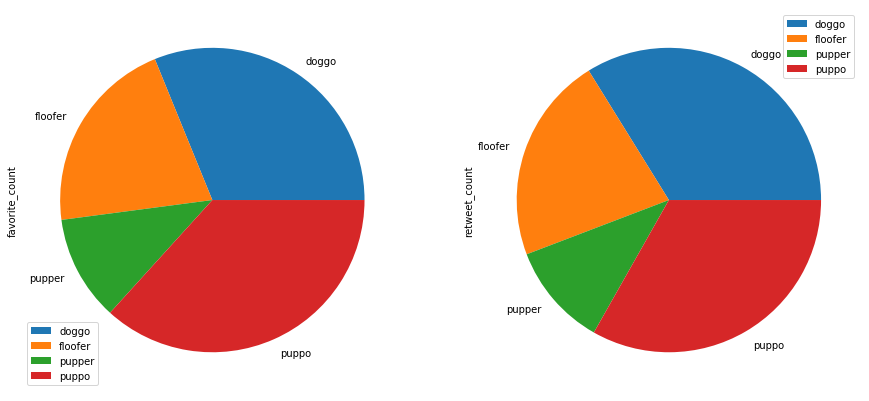

In [134]:
mean_stage = twt_archv_mstr.loc[twt_archv_mstr.dog_stage.notnull()].groupby(['dog_stage'],
                                                               as_index=False)['favorite_count','retweet_count'].mean()
print(mean_stage)
mean_stage.rename(index=mean_stage['dog_stage'], inplace=True)
mean_stage.plot(x='dog_stage',y=['favorite_count','retweet_count'],subplots=True,kind='Pie', figsize=(15,7));

It appears from the above analysis that doggo dogs (elderly ones) are more popular as the Puppo ones (small ones).

In [55]:
max_pred = twt_archv_mstr.groupby(['p1'], as_index=False)['favorite_count','retweet_count'].sum().sort_values(
    'favorite_count', ascending=False)
max_pred

,p1,favorite_count,retweet_count
183,golden_retriever,1544915,435365
44,Labrador_retriever,974263,305803
58,Pembroke,912563,242834
22,Chihuahua,631520,195923
64,Samoyed,470953,150837
31,French_bulldog,429369,104738
137,chow,372377,102067
281,pug,286232,84458
141,cocker_spaniel,282771,86146
59,Pomeranian,278838,93254


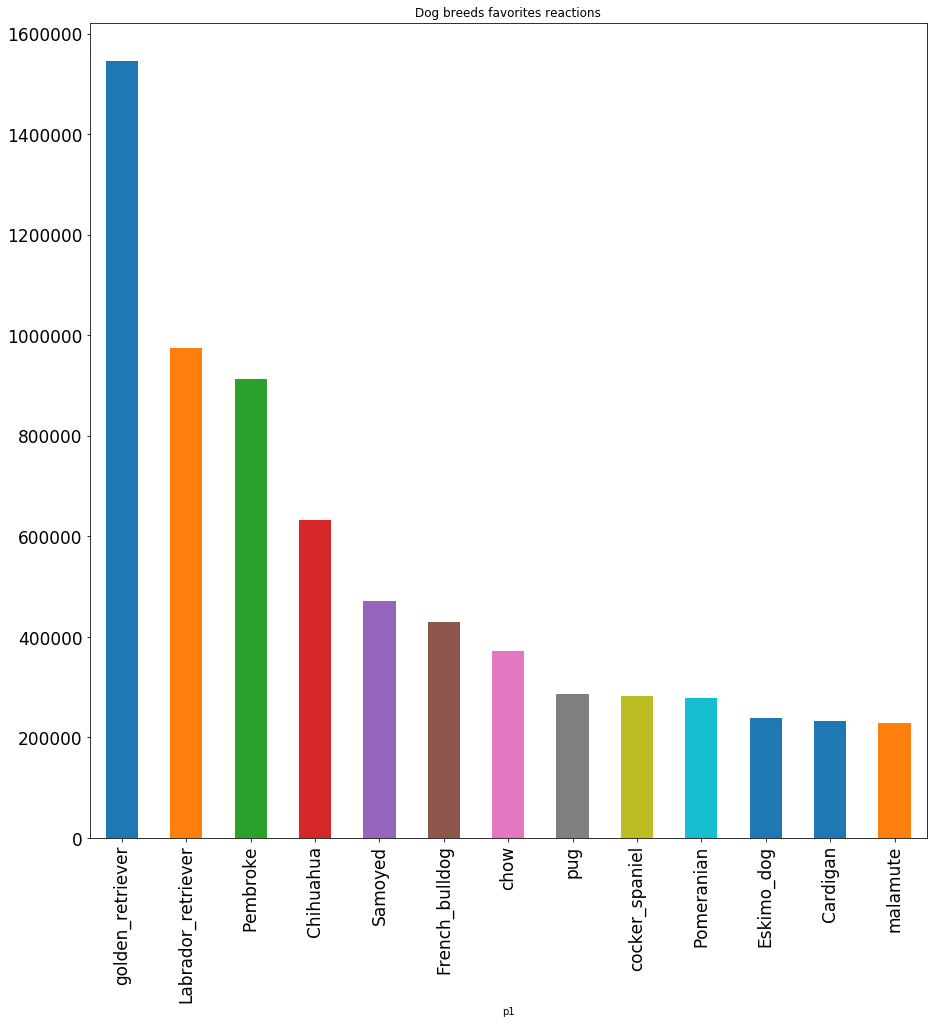

In [73]:
max_pred.iloc[:13,:].plot('p1','favorite_count', kind='bar',figsize=(15,15),title='Dog breeds favorites reactions',
                          legend=False, fontsize=17);